## Quantum reservoir computing

In this notebook we show how to design the quantum circuits that will be used as quantum reservoirs. We apply this framework to analyse the LiH molecule. The study for the H2O molecule is equivalent.

In [11]:
import numpy as np
from numpy.lib.scimath import sqrt as csqrt
from qiskit import QuantumCircuit
from qiskit import BasicAer
from qiskit.compiler import transpile
from qiskit.quantum_info import Statevector
from scipy.stats import unitary_group

from qiskit.opflow import StateFn
from qiskit.opflow import Z,X,Y
from qiskit.quantum_info import Pauli
from qiskit.opflow import *
from qiskit.circuit.library import Diagonal
from qiskit.extensions import  UnitaryGate

import random
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

import itertools

In [3]:
with open('../training_data/spectrums_LiH.npy', 'rb') as f:
            spectrums = np.load(f)
with open('../training_data/bond_lengths_LiH.npy', 'rb') as f:
            bond_lengths = np.load(f)
with open('../training_data/ground_states_LiH.npy', 'rb') as f:
            ground_states = np.load(f)

## Initialize the quantum circuit

The input quantum state of the quantum circuit is the ground state of the molecule. Therefore, we need to initialize the circuit with a state different than $|00..0>$. We use Qiskit to create the circuit to initialize the quantum circuit.

In [5]:
initial_state = ground_states[-1].round(6)
initial_state/=np.sqrt(np.sum(initial_state**2))

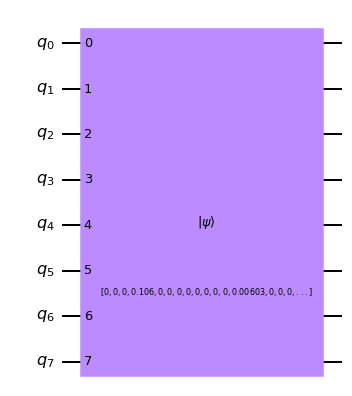

In [6]:
nqbits = 8
qc = QuantumCircuit(nqbits)
qc.initialize(initial_state, list(range(nqbits)))
qc.draw('mpl')

We check that the circuit in fact creates the initial state that we want. We measure the final state and compared to the ground state.

In [7]:
backend = BasicAer.get_backend('statevector_simulator')
job = backend.run(transpile(qc, backend))
qc_state = job.result().get_statevector(qc)
print('Proportion of equal values', np.sum(np.isclose(qc_state, initial_state))/len(qc_state))

Statevector(qc_state).to_dict()

Proportion of equal values 1.0


{'00000011': (0.10606201687351408+3.647689789110231e-15j),
 '00001100': (0.006030000959318965+2.1833121248426846e-16j),
 '00010010': (-0.2384140379295315-8.8557633448616e-15j),
 '00100001': (0.23841403792953178+8.939030071708487e-15j),
 '00110000': (0.4589690730178548+1.6767837118791817e-14j),
 '01000010': (-0.06954201106350928-2.5786664470395237e-15j),
 '01100000': (0.1457780231919744+5.411903564178644e-15j),
 '10000001': (0.06954201106350925+2.2833297752544723e-15j),
 '10010000': (-0.14577802319197355-5.417107734606574e-15j),
 '11000000': (-0.7824351244783991-2.7564756033271465e-14j)}

Now that we have checked that the circuit reproduced the initial state, we create the actual quantum circuit that we use as a reservoir.

## Create the quantum circuit

Now we define the gates applied to the quantum circuit. In this case, we will sample the gates from the set 

$$
G_1 = \{CNOT, H, X\}
$$

where CNOT is the controlled-NOT gate, H stands for Hadamard, and X is the NOT gate. We generate the gates randomly and select the qubit where it applies also randomly.

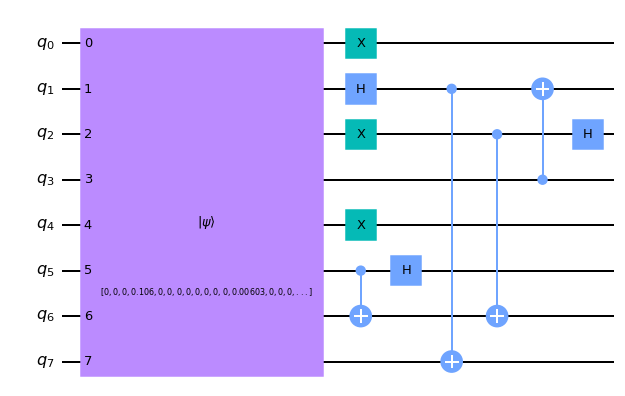

In [16]:
num_gates=10
nqbits = 8
gates_set = ['CNOT', 'X', 'H']
gate_idx = list(range(len(gates_set)))
qubit_idx = list(range(nqbits))

# Initialize quantum circuit
qc = QuantumCircuit(nqbits)
qc.initialize(initial_state, list(range(nqbits)))


# Apply random gates to random qubits
for i in range(num_gates):
    # Select random gate
    # Select random gate
    idx = random.sample(gate_idx,1)[0] 
    gate = gates_set[idx]
    if gate=='CNOT': # For 2-qubit gates
        # Select qubit 1 and 2 (different qubits)
        qbit1 = random.sample(qubit_idx,1)[0]
        qubit_idx2 = qubit_idx.copy()
        qubit_idx2.remove(qbit1)
        qbit2 = random.sample(qubit_idx2,1)[0]
        # Apply gate to qubits
        qc.cx(qbit1, qbit2) 
    else: # For 1-qubit gates
        # Select qubit
        qbit = random.sample(qubit_idx,1)[0]
        if gate=='X':# Apply gate
            qc.x(qbit) 
        if gate=='S':
            qc.s(qbit) 
        if gate=='H':
            qc.h(qbit) 
        if gate=='T':
            qc.t(qbit) 
qc.draw('mpl')

## Define observables to measure

We measure 
$$
<X_0>, <Y_0>, <Z_0>, \cdots, <X_7>, <Y_7>, <Z_7>
$$

In [17]:
observables = []
name_gate=''
for i in range(nqbits):
    name_gate+= 'I' 
for i in range(nqbits):
    # X
    op_nameX = name_gate[:i] + 'X' + name_gate[(i+1):]
    obs = PauliOp(Pauli(op_nameX))
    observables.append(obs)
    # Y
    op_nameY = name_gate[:i] + 'Y' + name_gate[(i+1):]
    obs = PauliOp(Pauli(op_nameY))
    observables.append(obs)
    # Z
    op_nameZ = name_gate[:i] + 'Z' + name_gate[(i+1):]
    obs = PauliOp(Pauli(op_nameZ))
    observables.append(obs)

We now call the backen to calculate the expected values of these operators.

In [18]:
results = []
backend = BasicAer.get_backend('statevector_simulator')
job = backend.run(transpile(qc, backend))
qc_state = job.result().get_statevector(qc)

for obs in observables:
    obs_mat = obs.to_spmatrix()
    expect = np.inner(np.conjugate(qc_state), obs_mat.dot(qc_state)).real
    results.append(expect)

In [19]:
print(np.array(results).round(4))

[-0.     -0.      0.      0.     -0.      0.7691  0.4225 -0.     -0.
 -0.      0.     -0.4225 -0.     -0.      0.9999 -0.9999  0.      0.
  0.     -0.     -0.     -0.      0.     -0.8541]


## Studied gates

In this section we present all the sets of gates that we will study. In particular, we study seven sets of gates:

1. $G_1=\{\text{CNOT, H, NOT}\}$
2. $G_2=\{\text{CNOT, H, S}\}$
3. $G_3=\{\text{CNOT, H, T}\}$
4. **Matchgate circuits**. Matchgates are two-qubit gates formed from two one-qubit gates A and B with the same determinant: A acts on the even-parity subspace (spanned by |00> and |11>) and B acts on the odd-parity subspace (spanned by |01> and |10>).

$$
G(A,B) = 
\begin{pmatrix} 
a_1 & 0 & 0 & a_2 \\
0 & b_1 & b_2 & 0 \\
0 & b_3 & b_4 & 0 \\
a_3 & 0 & 0 & a_4
\end{pmatrix}, \quad |A| = |B|
$$

5. $D_2$. Diagonal gate of two qubits. For every pair of qubits, we apply the diagonal gate:

$$
D_2(\phi_1, \cdots, \phi_4) = 
\begin{pmatrix} 
e^{i\phi_1} & 0 & 0 & 0 \\
0 & e^{i\phi_2} & 0 & 0 \\
0 & 0 & e^{i\phi_3} & 0 \\
0 & 0 & 0 & e^{i\phi_4}
\end{pmatrix}
$$

With $\phi_i$ chosen randomly from $[0, 2\pi)$. All the gates can be applied simultanously. There are $n(n-1)/2$ gates, for $n$ qubits. For $n=8$, there are 28 gates.

6. $D_3$. Diagonal gate of tree qubits. For every triplet of qubits, we apply the diagonal gate:
$$
D_3(\phi_1, \cdots, \phi_8) = 
\begin{pmatrix} 
e^{i\phi_1} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & e^{i\phi_2} & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & e^{i\phi_3} & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & e^{i\phi_4} & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & e^{i\phi_5} & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & e^{i\phi_6} & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & e^{i\phi_7} & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & e^{i\phi_8}\\
\end{pmatrix}
$$

With $\phi_i$ chosen randomly from $[0, 2\pi)$. All the gates can be applied simultanously. There are $n(n-1)(n-2)/6$ gates, for $n$ qubits. For $n=8$ there are 56 gates.

7. $D_n$. Diagonal gate for all the qubits. Only one gate is applied to the circuit.

$$
D_n(\phi_1, \cdots, \phi_{2^n}) = 
\begin{pmatrix} 
e^{i\phi_1} & 0 & \cdots & 0  \\
0 & e^{i\phi_2} & \cdots & 0 \\
\vdots & \vdots  & \ddots & \vdots \\
 0 & 0 & \cdots & e^{i\phi_{2^n}}
\end{pmatrix}
$$


With $\phi_i$ chosen randomly from $[0, 2\pi)$.

# All together

We define a function wich takes as input the ground state of the system and the parameters of the circuit (number of gates, gate set, observables) and outputs the expected value of the observables.

In [22]:
class QuantumCircQiskit:
    def __init__(self, gates_name, num_gates=50,nqbits=8,observables_type = 'single'):
        
        self.num_gates = num_gates
        self.gates_name = gates_name
        self.observables_type = observables_type
        self.gates_set = []
        self.qubits_set = []
        self.nqbits=nqbits
        if self.gates_name=='G1':
            gates = ['CNOT', 'H', 'X']
        if self.gates_name=='G2':
            gates = ['CNOT', 'H', 'S']
        if self.gates_name=='G3':
            gates = ['CNOT', 'H', 'T']  
        
        qubit_idx = list(range(self.nqbits))
        # Store gates
        if self.gates_name in ['G1', 'G2', 'G3']:
            for i in range(self.num_gates):
                # Select random gate
                gate = random.sample(gates,1)[0] 
                self.gates_set.append(gate)
                if gate=='CNOT':
                    # Select qubit 1 and 2 (different qubits)
                    qbit1 = random.sample(qubit_idx,1)[0]
                    qubit_idx2 = qubit_idx.copy()
                    qubit_idx2.remove(qbit1)
                    qbit2 = random.sample(qubit_idx2,1)[0]
                    self.qubits_set.append([qbit1, qbit2])
                else:
                    # Select qubit
                    qbit = random.sample(qubit_idx,1)[0]
                    self.qubits_set.append([qbit])
        elif self.gates_name=='D2':
            qubit_idx = list(range(self.nqbits))
            self.qubits_set = list(itertools.combinations(qubit_idx, 2))
            self.phis = np.random.uniform(0, 2*np.pi, size=(len(self.qubits_set), 2**2))
        elif self.gates_name=='D3':
            qubit_idx = list(range(self.nqbits))
            self.qubits_set = list(itertools.combinations(qubit_idx, 3))
            self.phis = np.random.uniform(0, 2*np.pi, size=(len(self.qubits_set), 2**3))
        elif self.gates_name=='Dn':
            self.phis = np.random.uniform(0, 2*np.pi, size=(2**self.nqbits))
        elif self.gates_name=='MG':
            for i in range(self.num_gates):
                G = self.matchgate()
                self.gates_set.append(G)
                qbit1 = random.sample(qubit_idx,1)[0]
                qubit_idx2 = qubit_idx.copy()
                qubit_idx2.remove(qbit1)
                qbit2 = random.sample(qubit_idx2,1)[0]
                self.qubits_set.append([qbit1, qbit2])

                
    def initialization(self, initial_state):
        # 1. INITIALIZATION
        # Define initial state
        initial_state = initial_state.round(6)
        initial_state/=np.sqrt(np.sum(initial_state**2))

        # Define qiskit circuit to initialize quantum state
        self.nqbits = int(np.log2(initial_state.shape[0]))
        qc = QuantumCircuit(nqbits)
        qc.initialize(initial_state, list(range(nqbits)))
        return qc

    def apply_G_gates(self, qc):
        # Apply random gates to random qubits
        for i in range(self.num_gates):
            # Select random gate
            # Select random gate
            gate = self.gates_set[i]
            if gate=='CNOT': # For 2-qubit gates
                # Select qubit 1 and 2 (different qubits)
                qbit1, qbit2 = self.qubits_set[i]
                # Apply gate to qubits
                qc.cx(qbit1, qbit2) 
            else: # For 1-qubit gates
                # Select qubit
                qbit = self.qubits_set[i][0]
                if gate=='X':# Apply gate
                    qc.x(qbit) 
                if gate=='S':
                    qc.s(qbit) 
                if gate=='H':
                    qc.h(qbit) 
                if gate=='T':
                    qc.t(qbit) 
    
    def apply_matchgates(self, qc):
        for i in range(self.num_gates):
            gate = self.gates_set[i]
            qbit1, qbit2 = self.qubits_set[i]
            qc.unitary(gate, [qbit1, qbit2], label='MG')
            
    def matchgate(self):
        A = unitary_group.rvs(2)
        B = unitary_group.rvs(2)
        detA = np.linalg.det(A)
        detB = np.linalg.det(B)
        B = B/np.sqrt(detB)*np.sqrt(detA)
        G = np.array([[A[0,0],0,0,A[0,1]],[0,B[0,0], B[0,1],0],
                      [0,B[1,0],B[1,1],0],[A[1,0],0,0,A[1,1]]])
        return G
    
    def apply_Dn(self, qc):
        # Apply Dn gate
        diagonals = np.exp(1j*self.phis)
        qc += Diagonal(diagonals)
        
    def apply_D2(self, qc):
        i=0
        for pair in self.qubits_set:
            # Apply D2 gate
            diagonals = np.diag(np.exp(1j*self.phis[i]))
            D2 = UnitaryGate(diagonals)
            qc.append(D2, [pair[0], pair[1]])
            i+=1
            
    def apply_D3(self, qc):
        i=0
        for pair in self.qubits_set:
            # Apply D3 gate
            diagonals = np.diag(np.exp(1j*self.phis[i]))
            D3 = UnitaryGate(diagonals)
            qc.append(D3, [pair[0], pair[1], pair[2]])
            i+=1


    def get_observables(self):
        observables = []
        name_gate=''
        for i in range(self.nqbits):
            name_gate+= 'I' 
        for i in range(self.nqbits):
            # X
            op_nameX = name_gate[:i] + 'X' + name_gate[(i+1):]
            obs = PauliOp(Pauli(op_nameX))
            observables.append(obs)
            # Y
            op_nameY = name_gate[:i] + 'Y' + name_gate[(i+1):]
            obs = PauliOp(Pauli(op_nameY))
            observables.append(obs)
            # Z
            op_nameZ = name_gate[:i] + 'Z' + name_gate[(i+1):]
            obs = PauliOp(Pauli(op_nameZ))
            observables.append(obs)
        return observables

    def run_circuit(self, initial_state):

        # 1. INITIALIZATION
        qc = self.initialization(initial_state)
        
        # 2. DEFINE RANDOM CIRCUIT
        if self.gates_name in ['G1', 'G2', 'G3']:
            self.apply_G_gates(qc)
        elif self.gates_name=='D2':
            self.apply_D2(qc)
        elif self.gates_name=='D3':
            self.apply_D3(qc)
        elif self.gates_name=='Dn':
            self.apply_Dn(qc)
        elif self.gates_name=='MG':
            self.apply_matchgates(qc)
        else:
            print('Unknown gate')

        # Obtain circuit
        #circuit = qc.to_circ()

        # 3. DEFINE OBSERVABLES
        # Define observables to measure
        if self.observables_type=='single':
            observables = self.get_observables()

        # 4. RUN CIRCUIT
        results = []
        
        backend = BasicAer.get_backend('statevector_simulator')
        job = backend.run(transpile(qc, backend))
        qc_state = job.result().get_statevector(qc)

        for obs in observables:
            obs_mat = obs.to_spmatrix()
            expect = np.inner(np.conjugate(qc_state), obs_mat.dot(qc_state)).real
            results.append(expect)

        return np.array(results)

In [26]:
# Run circuit for all values of ground states:
obs_res = []
num_states =ground_states.shape[0]
qc = QuantumCircQiskit('G1', num_gates=20,nqbits=8,observables_type = 'single')

for i in tqdm(range(num_states)):
    res = qc.run_circuit(ground_states[i])
    obs_res.append(res)
obs_res = np.array(obs_res)    

100%|██████████| 300/300 [25:56<00:00,  5.19s/it]


## Generate target

The target of the model is

$$
y(t) = (\Delta E_1(r), \Delta E_2(r))
$$

We normalize $y(r)$ so that it lies between 0 and 1 for all the data.

In [27]:
y = np.zeros((num_states, 2))
y[:,0] = spectrums[:,1] - spectrums[:,0]
y[:,1] = spectrums[:,2] - spectrums[:,0]

## Train and test data

In [28]:
X_train, X_test, y_train, y_test, bond_lengths_train, bond_lengths_test = train_test_split( 
    obs_res, y, bond_lengths, test_size=0.33, random_state=42)

## Scale y

In [29]:
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

## Train Ridge regression

In [32]:
lm = Ridge(alpha=1e-7)
lm.fit(X_train, y_train_scaled)

Ridge(alpha=1e-07)

## Test model

Mean Square Error  9.583468318493517e-06


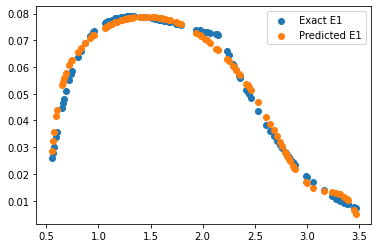

In [33]:
y_hat = lm.predict(X_test)
y_hat = scaler.inverse_transform(y_hat)

mse = np.mean(np.square(y_hat - y_test))
print('Mean Square Error ', mse)

plt.scatter(bond_lengths_test,y_test[:,0], label='Exact E1', marker='o')
plt.scatter(bond_lengths_test, y_hat[:,0], label='Predicted E1', marker='o')
plt.legend()
plt.show()

Now we just have to repeat this experiment 400 times for all the families of gates. The scripts `runQC`and `runQC_H2O` can be used to run the simulations. To run them, just type:

`python runQC.py num_gates gates_set observable_type `

where 

+ num_gates is the number of gates (in this work we have used 20, 50, 100, 150, 200)
+ gates_set is the name of the gate set, from the list [G1, G2, G3, MG, D2, D3, Dn]
+ and observable_type must be single